# Central Alps packaging

"Package" the result of Central-Alps-merge.ipynb into 3 sub-2GB files, with a z9 white layer.

In [1]:
%load_ext autoreload
%autoreload 2

import os
NBROOT = os.path.realpath(os.curdir)

In [44]:
# Preamble
import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('PIL').level = logging.INFO # PIL.PngImagePlugin

import os
from os.path import exists, join as pjoin, realpath
from pathlib import Path

from subprocess import check_call, CalledProcessError

try:
    # like os.system but with live output
    from IPython.utils.process import system
    def check_run(cmd):  # type:ignore
        r = system(cmd)
        if r: raise CalledProcessError(r, cmd)
        return r
except ImportError:
    from os import system
    def check_run(cmd):
        return check_call(cmd, shell=True)

from IPython.display import Image as IImage
import mercantile as T

from src import bbox, gdal_slope_util as S, mbt_util as M, eslope_geo as GY

import sys
sys.path.insert(0, os.path.realpath('../../etopo/src'))
import img_util as G

In [47]:
mbtfold = '../../mapdata/mbtiles/eslo/'
mbtc = '../../slope-ign-alti/alpsc/esloAlpsC.mbtiles'
# mbtwc = '../../slope-ign-alti/alpsc/AlpsWC_eslo.mbtiles'

names = GY.bbsalp_names
paths = {i: name + '.mbtiles' for i, name in names.items()}
abspaths = {i: mbtfold + p for i, p in paths.items()}

mbtc7 = abspaths[7]
mbtc8 = abspaths[7]
mbtc12= abspaths[12]
# mbtc7 = mbtfold + 'esloAlpsC7.mbtiles'
# mbtc8 = mbtfold + 'esloAlpsC8.mbtiles'
# mbtc12 = mbtfold + 'esloAlpsC12.mbtiles'

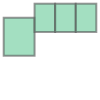

In [43]:
GY.extents2geojson('./data/eslope_alps_extents.geojson', GY.bbsalp, GY.bbsalp_names)
# GY.MultiPolygon(map(GY.bb2poly, list(GY.bbsalp.values())[:-1]))
GY.GeometryCollection([GY.bb2poly(GY.bbsalp[k]) for k in GY.bbsalp if isinstance(k, int)])

In [4]:
M.real_bounds('../../slope-ign-alti/alpsc/AlpsWC_eslo.mbtiles', log=print),\
M.real_bounds('../../slope-ign-alti/alpsc/esloAlpsC.mbtiles', log=print)


real bounds  9 [5.63, 43.58, 7.73, 46.56] 264 325 266 330
real bounds  13 [5.63, 43.58, 11.95, 47.52] 4224 5200 4367 5327
real bounds  14 [5.63, 43.58, 11.95, 47.52] 8448 10400 8735 10655
real bounds  15 [5.63, 43.58, 11.95, 47.52] 16896 20800 17471 21311
real bounds  16 [5.63, 43.58, 11.95, 47.52] 33792 41600 34943 42623
real bounds  12 [7.65, 45.52, 11.95, 47.52] 2135 2631 2183 2663
real bounds  13 [7.69, 45.55, 11.95, 47.52] 4271 5263 4367 5327
real bounds  14 [7.71, 45.57, 11.95, 47.52] 8543 10527 8735 10655
real bounds  15 [7.72, 45.58, 11.95, 47.52] 17087 21055 17471 21311
real bounds  16 [7.73, 45.58, 11.95, 47.52] 34175 42111 34943 42623


((9,
  16,
  LngLatBbox(west=5.625000000000014, south=43.580390855607845, east=11.953125000000016, north=47.51720069783939)),
 (12,
  16,
  LngLatBbox(west=7.646484374999992, south=45.52174389699363, east=11.953125000000016, north=47.51720069783939)))

In [5]:
_, _, bbc = M.real_bounds(mbtc)
bbc  # this is inflated because of rounding errors during gdal generation

LngLatBbox(west=7.646484374999992, south=45.52174389699363, east=11.953125000000016, north=47.51720069783939)

In [6]:
bbc = GY.bbsalp['AlpsC']  # expected
z, x1, y1 = M.lnglat2tms(9, lng=bbc.west+.01, lat=bbc.south)
z, x2, y2 = M.lnglat2tms(9, lng=bbc.east-.01, lat=bbc.north)
x1, y1, x2, y2

(267, 329, 272, 332)

In [14]:
tiles_xyz = list(T.tiles(*GY.bbsalp['AlpsC'], [9]))
len(tiles_xyz), tiles_xyz[0], tiles_xyz[-1]  # note inverted Y compared to the above


(32, Tile(x=266, y=179, z=9), Tile(x=273, y=182, z=9))

In [15]:
# tiles_xyz = list(T.tiles(*GY.bbsalp['CAlps'], [9]))
tiles_xyz = list(T.tiles(*bbox.enlarge(GY.bbsalp['AlpsC'], -0.01), [9]))
len(tiles_xyz), tiles_xyz[0], tiles_xyz[-1]  # note inverted Y compared to the above


(24, Tile(x=267, y=179, z=9), Tile(x=272, y=182, z=9))

In [10]:
import io
from PIL import Image as Img
size = 256
img = Img.new('P', (size, size), color='white')
output = io.BytesIO()
img.save(output, 'PNG')
white_png = output.getvalue()

In [11]:
mbtwhite = mbtfold + 'AlpsC_white.mbtiles'
! rm $mbtwhite
with M.cursor(mbtwhite, create=True) as dbc:
    M.create_mbt(dbc)
    for x, y, z in tiles_xyz:
        y = (1 << z) - y - 1
        M.insert_tiles(dbc, [(z, x, y, white_png)])

    M.set_real_bounds(dbc)

M.mbt_info(mbtwhite)

'zoom = 9 9 ; n = 24 * 1 kb/tile ; bounds = 7.73437,45.58329,11.95312,47.5172 ; center = 9.84375,46.55025,9'

In [12]:
bbc

LngLatBbox(west=7.73437, south=45.58329, east=11.95313, north=47.5172)

In [21]:
M.mbt_merge(mbtwhite, dest=mbtc)

<< ../../mapdata/mbtiles/eslo/AlpsC_white : zoom = 9 9 ; n = 24 * 1 kb/tile ; bounds = 7.73437,45.58329,11.95312,47.5172 ; center = 9.84375,46.55025,9
>> ../../slope-ign-alti/alpsc/esloAlpsC : zoom = 9 16 ; n = 526285 ; name = alpsc/AlpsC_eslo ; format = png ; bounds = 7.73399999999999999,45.5829616352129463,11.9530933227539062,47.5169999999999959
Meta update {'bounds': '7.64648,45.52174,11.95313,47.5172',
 'center': '9.79980,46.51947,9',
 'maxzoom': 16,
 'minzoom': 9,
 'type': 'baselayer'}


In [22]:
M.remove_lnglat(mbtc, zmin=10, zmax=12, overwrite=True)

<<>> ../../slope-ign-alti/alpsc/esloAlpsC : zoom = 9 16 ; n = 526285 * 10 kb/tile ; bounds = 7.64648,45.52174,11.95313,47.5172 ; center = 9.79980,46.51947,9 ; format = png ; name = alpsc/AlpsC_eslo
z 10 : removed 0
z 11 : removed 0
z 12 : removed 1617
Meta update {'bounds': '7.69043,45.55253,11.95313,47.5172',
 'center': '9.82178,46.53486,9',
 'maxzoom': 16,
 'minzoom': 9,
 'type': 'baselayer'}


In [26]:
!gpxsee $mbtc7

QSocketNotifier: Can only be used with threads started with QThread


In [24]:
M.cut_to_lnglat(mbtc, bb=GY.bbsalp[7], dest=mbtc7)

zoom = 9 16 ; n = 524668 * 10 kb/tile ; bounds = 7.69043,45.55253,11.95313,47.5172 ; center = 9.82178,46.53486,9 ; format = png ; name = alpsc/AlpsC_eslo
cut_to_lnglat ../../slope-ign-alti/alpsc/esloAlpsC.mbtiles -> ../../mapdata/mbtiles/eslo/esloAlpsC7.mbtiles
9 16 16
z 9: +8 tiles: 267<x<268 329<y<332
z10: no tiles, skipping
z11: no tiles, skipping
z12: no tiles, skipping
z 13: +2048 tiles: 4272<x<4303 5264<y<5327
z 14: +8192 tiles: 8544<x<8607 10528<y<10655
z 15: +32768 tiles: 17088<x<17215 21056<y<21311
z 16: +131072 tiles: 34176<x<34431 42112<y<42623
Meta update {'bounds': '7.73437,45.58329,9.14063,47.5172',
 'center': '8.43750,46.55025,9',
 'maxzoom': 16,
 'minzoom': 9,
 'type': 'baselayer'}


In [27]:
M.real_bounds(mbtc7, log=print)

real bounds  9 [7.73, 45.58, 9.14, 47.52] 267 329 268 332
real bounds  13 [7.73, 45.58, 9.14, 47.52] 4272 5264 4303 5327
real bounds  14 [7.73, 45.58, 9.14, 47.52] 8544 10528 8607 10655
real bounds  15 [7.73, 45.58, 9.14, 47.52] 17088 21056 17215 21311
real bounds  16 [7.73, 45.58, 9.14, 47.52] 34176 42112 34431 42623


(9,
 16,
 LngLatBbox(west=7.734374999999989, south=45.58328975600631, east=9.140625000000004, north=47.51720069783939))

In [31]:
M.cut_to_lnglat(mbtc, bb=GY.bbsalp[8], dest=mbtc8)

zoom = 9 16 ; n = 524668 * 10 kb/tile ; bounds = 7.73437,45.58329,9.14063,47.5172 ; center = 8.43750,46.55025,9 ; format = png ; name = alpsc/AlpsC_eslo
cut_to_lnglat ../../slope-ign-alti/alpsc/esloAlpsC.mbtiles -> ../../mapdata/mbtiles/eslo/esloAlpsC8.mbtiles
9 16 16
z 9: +8 tiles: 269<x<270 329<y<332
z10: no tiles, skipping
z11: no tiles, skipping
z12: no tiles, skipping
z 13: +2048 tiles: 4304<x<4335 5264<y<5327
z 14: +8192 tiles: 8608<x<8671 10528<y<10655
z 15: +32768 tiles: 17216<x<17343 21056<y<21311
z 16: +131072 tiles: 34432<x<34687 42112<y<42623
Meta update {'bounds': '9.14062,45.58329,10.54688,47.5172',
 'center': '9.84375,46.55025,9',
 'maxzoom': 16,
 'minzoom': 9,
 'type': 'baselayer'}


In [33]:
M.cut_to_lnglat(mbtc, bb=GY.bbsalp[12], dest=mbtc12)

zoom = 9 16 ; n = 524668 * 10 kb/tile ; bounds = 9.14062,45.58329,10.54688,47.5172 ; center = 9.84375,46.55025,9 ; format = png ; name = alpsc/AlpsC_eslo
cut_to_lnglat ../../slope-ign-alti/alpsc/esloAlpsC.mbtiles -> ../../mapdata/mbtiles/eslo/esloAlpsC12.mbtiles
9 16 16
z 9: +8 tiles: 271<x<272 329<y<332
z10: no tiles, skipping
z11: no tiles, skipping
z12: no tiles, skipping
z 13: +2048 tiles: 4336<x<4367 5264<y<5327
z 14: +8192 tiles: 8672<x<8735 10528<y<10655
z 15: +32768 tiles: 17344<x<17471 21056<y<21311
z 16: +131072 tiles: 34688<x<34943 42112<y<42623
Meta update {'bounds': '10.54688,45.58329,11.95313,47.5172',
 'center': '11.25000,46.55025,9',
 'maxzoom': 16,
 'minzoom': 9,
 'type': 'baselayer'}


In [50]:
for i in names:
# for i, mbt in paths.items():
    mbt = abspaths[i]
    name = names[i]
    # if not os.path.exists(mbt):
    #     continue
    web = '<a href="https://github.com/eslopemap/eslope">eSlope</a>'
    desc = f'Enhanced slope maps, {name} area.\nDocumentation: {web}'
    M.update_mbt_meta(mbt, name=name, desc=desc, attrib='© ' + web)
    print(i, 'd:', M.get_meta(mbt)['description'], '\na:', M.get_meta(mbt).get('attribution'))
    print()

1 d: Enhanced slope maps, esloAlps1-Annot-Lausanne-Zermatt area.
Documentation: <a href="https://github.com/eslopemap/eslope">eSlope</a> 
a: © <a href="https://github.com/eslopemap/eslope">eSlope</a>

7 d: Enhanced slope maps, esloAlps7-Como-Zermatt-Zurich area.
Documentation: <a href="https://github.com/eslopemap/eslope">eSlope</a> 
a: © <a href="https://github.com/eslopemap/eslope">eSlope</a>

8 d: Enhanced slope maps, esloAlps8-Lombardia-Grisons-Vorarlberg area.
Documentation: <a href="https://github.com/eslopemap/eslope">eSlope</a> 
a: © <a href="https://github.com/eslopemap/eslope">eSlope</a>

12 d: Enhanced slope maps, esloAlps12-Tirol-Arco-Innsbruck-Bruneck-Marmolada area.
Documentation: <a href="https://github.com/eslopemap/eslope">eSlope</a> 
a: © <a href="https://github.com/eslopemap/eslope">eSlope</a>



In [ ]:
for i, p in abspaths.items():
    system('gh release delete-asset -y 202301 ' + paths[i])
    system('gh release upload 202301 ' + p)